https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner

- The Age feature is missing approximately 19.8% of its values. I'm guessing that the Age feature is pretty important to survival, so we should probably attempt to fill these gaps.
- The Cabin feature is missing approximately 77.1% of its values. Since so much of the feature is missing, it would be hard to fill in the missing values. We'll probably drop these values from our dataset.
- **I think the idea here is that people with recorded cabin numbers are of higher socioeconomic class, and thus more likely to survive.**
- **we'll try to predict the missing Age values from the most common age for their Title.**

https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

- **looking at the relationship between the length of a name and survival rate appears to indicate that there is indeed a clear relationship. What might this mean? Are people with longer names more important, and thus more likely to be prioritized in a shipwreck?**
- **There are 177 nulls for Age, and they have a 10% lower survival rate than the non-nulls. Before imputing values for the nulls, we will include an Age_null flag just to make sure we can account for this characteristic of the data.**

In [1]:
import time

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# train, test, validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

# decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

# feature engineering
from sklearn.preprocessing import PolynomialFeatures

# feature selection
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
combine = [train_df, test_df]

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_df.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Carlsson, Mr. Frans Olof",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [6]:
train_df.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Carlsson, Mr. Frans Olof",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [7]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
train_df.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [9]:
train_df[["Age", "Cabin", "Embarked"]].head()

,Age,Cabin,Embarked
0,22.0,NaN,S
1,38.0,C85,C
2,26.0,NaN,S
3,35.0,C123,S
4,35.0,NaN,S


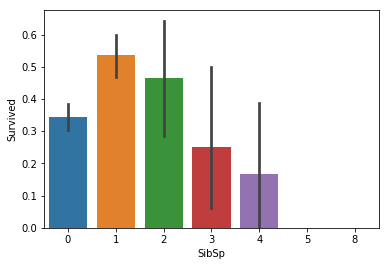

In [10]:
sns.barplot(data=train_df, x="SibSp", y="Survived")

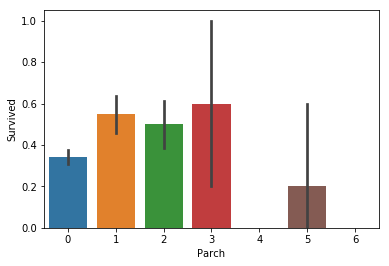

In [11]:
sns.barplot(data=train_df, x="Parch", y="Survived")

In [12]:
train_df_filled_Age = train_df.Age.fillna(-1)

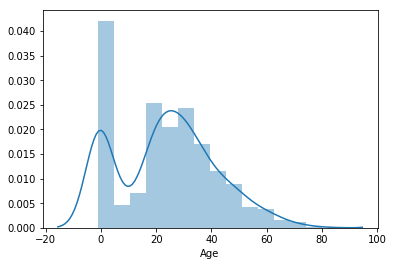

In [13]:
sns.distplot(train_df_filled_Age)

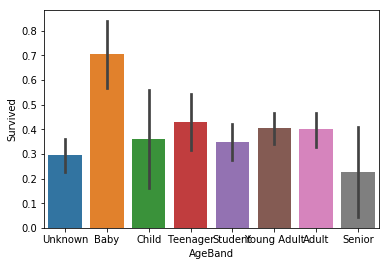

In [14]:
train_df["Age"] = train_df["Age"].fillna(-0.5)
test_df["Age"] = test_df["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ["Unknown", "Baby", "Child", "Teenager", 'Student', 'Young Adult', 'Adult', 'Senior']
train_df["AgeBand"] = pd.cut(train_df["Age"], bins, labels= labels)
test_df["AgeBand"] = pd.cut(test_df["Age"], bins, labels= labels)

sns.barplot(x="AgeBand", y="Survived", data=train_df)
plt.show()

Percentage of CabinBool = 1 who survived: 66.66666666666666
Percentage of CabinBool = 0 who survived: 29.985443959243085


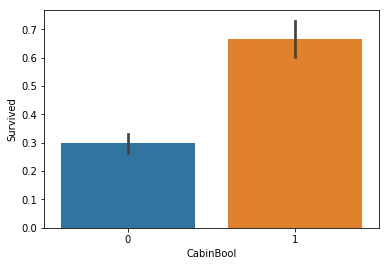

In [15]:
train_df["CabinBool"] = (train_df["Cabin"].notnull().astype('int'))
test_df["CabinBool"] = (test_df["Cabin"].notnull().astype('int'))

#calculate percentages of CabinBool vs. survived
print("Percentage of CabinBool = 1 who survived:", 
      train_df["Survived"][train_df["CabinBool"] == 1].value_counts(normalize = True)[1]*100)

print("Percentage of CabinBool = 0 who survived:", 
      train_df["Survived"][train_df["CabinBool"] == 0].value_counts(normalize = True)[1]*100)
#draw a bar plot of CabinBool vs. survival
sns.barplot(x="CabinBool", y="Survived", data=train_df)
plt.show()

In [16]:
train_df["Survived"][train_df["CabinBool"]==1].value_counts(normalize=True)

1    0.666667
0    0.333333
Name: Survived, dtype: float64

In [17]:
cabindata = train_df["Cabin"].dropna()
cabindata.iloc[0][0]

'C'

In [18]:
train_df["Cabin"].fillna('0').head()

0       0
1     C85
2       0
3    C123
4       0
Name: Cabin, dtype: object

In [19]:
train_df["CabinCat"] = train_df["Cabin"].fillna('0').apply(lambda x: x[0])
train_df["CabinCat"].value_counts()

0    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: CabinCat, dtype: int64

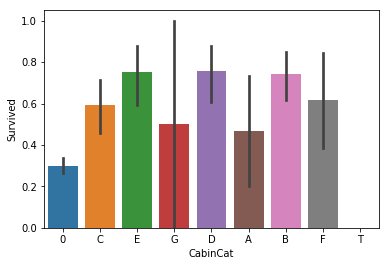

In [20]:
sns.barplot(data=train_df, x="CabinCat", y="Survived")

https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

In [21]:
train_df['Name_Len'] = train_df['Name'].apply(lambda x: len(x))
train_df['Survived'].groupby(pd.qcut(train_df['Name_Len'],5)).mean()

Name_Len
(11.999, 19.0]    0.220588
(19.0, 23.0]      0.301282
(23.0, 27.0]      0.319797
(27.0, 32.0]      0.442424
(32.0, 82.0]      0.674556
Name: Survived, dtype: float64

In [22]:
pd.qcut(train_df['Name_Len'],5).value_counts()

(11.999, 19.0]    204
(23.0, 27.0]      197
(32.0, 82.0]      169
(27.0, 32.0]      165
(19.0, 23.0]      156
Name: Name_Len, dtype: int64

In [23]:
train_df['Name_Len'] = train_df['Name'].apply(lambda x: len(x))
train_df['Survived'].groupby(pd.cut(train_df['Name_Len'],5)).mean()

Name_Len
(11.93, 26.0]    0.270217
(26.0, 40.0]     0.452381
(40.0, 54.0]     0.810127
(54.0, 68.0]     0.700000
(68.0, 82.0]     1.000000
Name: Survived, dtype: float64

In [24]:
pd.cut(train_df['Name_Len'],5).value_counts()

(11.93, 26.0]    507
(26.0, 40.0]     294
(40.0, 54.0]      79
(54.0, 68.0]      10
(68.0, 82.0]       1
Name: Name_Len, dtype: int64

In [25]:
train_df["CabinLetter"] = train_df["Cabin"].apply(lambda x: str(x)[0])
train_df["CabinLetter"].head()

0    n
1    C
2    n
3    C
4    n
Name: CabinLetter, dtype: object

In [36]:
train_df["CabinLetter"].value_counts()

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: CabinLetter, dtype: int64

In [39]:
train_df["Survived"].groupby(train_df['CabinLetter']).mean()

CabinLetter
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
n    0.299854
Name: Survived, dtype: float64

In [34]:
train_df.groupby("CabinLetter").mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,CabinBool,Name_Len
CabinLetter,,,,,,,,,
A,439.600000,0.466667,1.000000,35.766667,0.133333,0.133333,39.623887,1.0,29.866667
B,521.808511,0.744681,1.000000,33.446809,0.361702,0.574468,113.505764,1.0,30.276596
C,406.440678,0.593220,1.000000,31.125763,0.644068,0.474576,100.151341,1.0,31.661017
D,475.939394,0.757576,1.121212,36.636364,0.424242,0.303030,57.244576,1.0,29.787879
E,502.437500,0.750000,1.312500,35.703125,0.312500,0.312500,46.026694,1.0,27.906250
F,370.384615,0.615385,2.384615,16.807692,0.538462,0.538462,18.696792,1.0,28.538462
G,216.000000,0.500000,3.000000,14.750000,0.500000,1.250000,13.581250,1.0,37.500000
T,340.000000,0.000000,1.000000,45.000000,0.000000,0.000000,35.500000,1.0,28.000000
n,443.208151,0.299854,2.639010,21.102984,0.547307,0.365357,19.157325,0.0,26.000000


In [40]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBand,CabinBool,CabinCat,Name_Len,CabinLetter
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Student,0,0,23,n
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adult,1,C,51,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Young Adult,0,0,22,n
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Young Adult,1,C,44,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Young Adult,0,0,24,n
